<a href="https://colab.research.google.com/github/Jion-25/AIMS-LAB-Assignment/blob/main/Modified_Final_Tomato_CNN_with_Attention_Mechanism_%2B_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tomato Leaf Disease Classification with Customized CNN Approach: CBAM  + SE + Spatial Attention + Residual Connections with Grad-CAM XAI Visualization**

## **Import Necessary Libraries and Modules**

In [ ]:
from google.colab import drive
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D # Importing GlobalMaxPooling2D
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape,
                                     Multiply, Flatten, Dropout, Add, LayerNormalization,
                                     DepthwiseConv2D, MultiHeadAttention, Concatenate, AveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.models import load_model
import datetime

# Enable mixed precision training globally
set_global_policy('mixed_float16')

# **Load Dataset from Drive**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ==========================
# Dataset Split (Parallel)
# ==========================
dataset_path = "/content/drive/MyDrive/PlantVillage_ Tomato Leaf Dataset"
output_base = "/content/drive/MyDrive/Tomato _ Split"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")

# Ensure output_base exists as well, as train_dir and test_dir are inside it.
os.makedirs(output_base, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(dataset_path)
split_ratio = 0.2

def copy_images(img, class_name, class_path, base_dest_dir):
    """Copies an image to the class subdirectory within the base destination directory."""
    src = os.path.join(class_path, img)
    # Construct the destination path including the class subdirectory
    dest_class_dir = os.path.join(base_dest_dir, class_name)
    os.makedirs(dest_class_dir, exist_ok=True) # Ensure the class directory exists
    dst = os.path.join(dest_class_dir, img)
    shutil.copy2(src, dst)

def process_class(class_name):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        return # Skip if it's not a directory
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if not images:
        print(f"No images found in class directory: {class_path}")
        return # Skip if no images are found

    print(f"Processing class: {class_name} with {len(images)} images.")

    train_images, test_images = train_test_split(images, test_size=split_ratio, random_state=42)

    # Pass the base train_dir and test_dir
    with ThreadPoolExecutor(max_workers=5) as executor: # Added max_workers for clarity, adjust as needed
        train_futures = [executor.submit(copy_images, img, class_name, class_path, train_dir) for img in train_images]
        test_futures = [executor.submit(copy_images, img, class_name, class_path, test_dir) for img in test_images]

        # Wait for all tasks to complete
        for future in train_futures + test_futures:
            future.result() # This will re-raise any exceptions

for class_name in classes:
    # Skip if the item in the dataset_path is not a directory (e.g., .ipynb_checkpoints)
    if os.path.isdir(os.path.join(dataset_path, class_name)):
        process_class(class_name)
    else:
        print(f"Skipping non-directory item in dataset_path: {class_name}")

print("✅ Dataset split completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing class: Tomato__Tomato_YellowLeaf__Curl_Virus with 3209 images.
Processing class: Tomato_Leaf_Mold with 952 images.
Processing class: Tomato__Target_Spot with 1404 images.
Processing class: Tomato_Early_blight with 1000 images.
Processing class: Tomato_Late_blight with 1909 images.
Processing class: Tomato_Septoria_leaf_spot with 1771 images.
Processing class: Tomato_Spider_mites_Two_spotted_spider_mite with 1676 images.
Processing class: Tomato_healthy with 1591 images.
Processing class: Tomato__Tomato_mosaic_virus with 373 images.
Processing class: Tomato_Bacterial_spot with 2129 images.
✅ Dataset split completed!


# **Initializing the Train Dataset**

In [ ]:
# Verify the contents of the train directory
print("\nContents of train directory:")
for root, dirs, files in os.walk(train_dir):
    level = root.replace(train_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

# After verification, proceed with the dataset loading
import tensorflow as tf # Importing tensorflow

dataset = tf.keras.utils.image_dataset_from_directory( # Replacing 'st' with 'tf'
    train_dir,
    batch_size = 16,
    image_size=(256, 256),
    seed=123,
    shuffle=True
)

Streaming output truncated to the last 5000 lines.
        281da113-7611-44bf-9df7-b742fcbce900___JR_Sept.L.S 8568.JPG
        f313bc43-c255-4921-acf9-335322107c45___Keller.St_CG 1864.JPG
        6bda66a5-562c-4ad9-9e14-7d76dcbd4eef___Keller.St_CG 1880.JPG
        846797a3-3eb3-403d-aeb3-816f8f2b53d9___Keller.St_CG 2029.JPG
        80857534-e2f2-4ba1-9beb-e4d6619f80eb___Matt.S_CG 1238.JPG
        8bf6fb90-0c85-4adf-a416-1c4c54ea5782___Matt.S_CG 6009.JPG
        4193a3fe-d859-4354-b9e7-ec143f24ca01___JR_Sept.L.S 2579.JPG
        2258389b-40c1-4d0e-9675-d7ea31239390___JR_Sept.L.S 8436.JPG
        1b3e0904-291b-45b4-8823-44084b96808c___Matt.S_CG 6582.JPG
        444b3794-ac77-4dab-a3d0-556086c7ec89___Matt.S_CG 1080.JPG
        1dba882a-8d8b-4f5e-a6d4-18f6c58534b3___Matt.S_CG 6782.JPG
        5ba3b6f4-7b05-4588-8063-078c48268e88___Keller.St_CG 1935.JPG
        a35eec16-f8d0-4caa-8c5a-d4f05658e287___Keller.St_CG 1952.JPG
        ba1d1b79-0317-4edc-9641-12d1a7c44055___JR_Sept.L.S 2501.JPG
  

# **Preprocessing our Dataset**

In [ ]:
# data_generator = ImageDataGenerator(rescale = 1/255)
# train_data = data_generator.flow_from_directory(train_dir,
#                                                target_size = (224, 224),
#                                                batch_size = 16)
# test_data = data_generator.flow_from_directory(test_dir,
#                                              target_size = (224,224),
#                                               batch_size = 16)

# **Visualizing Image Classes**

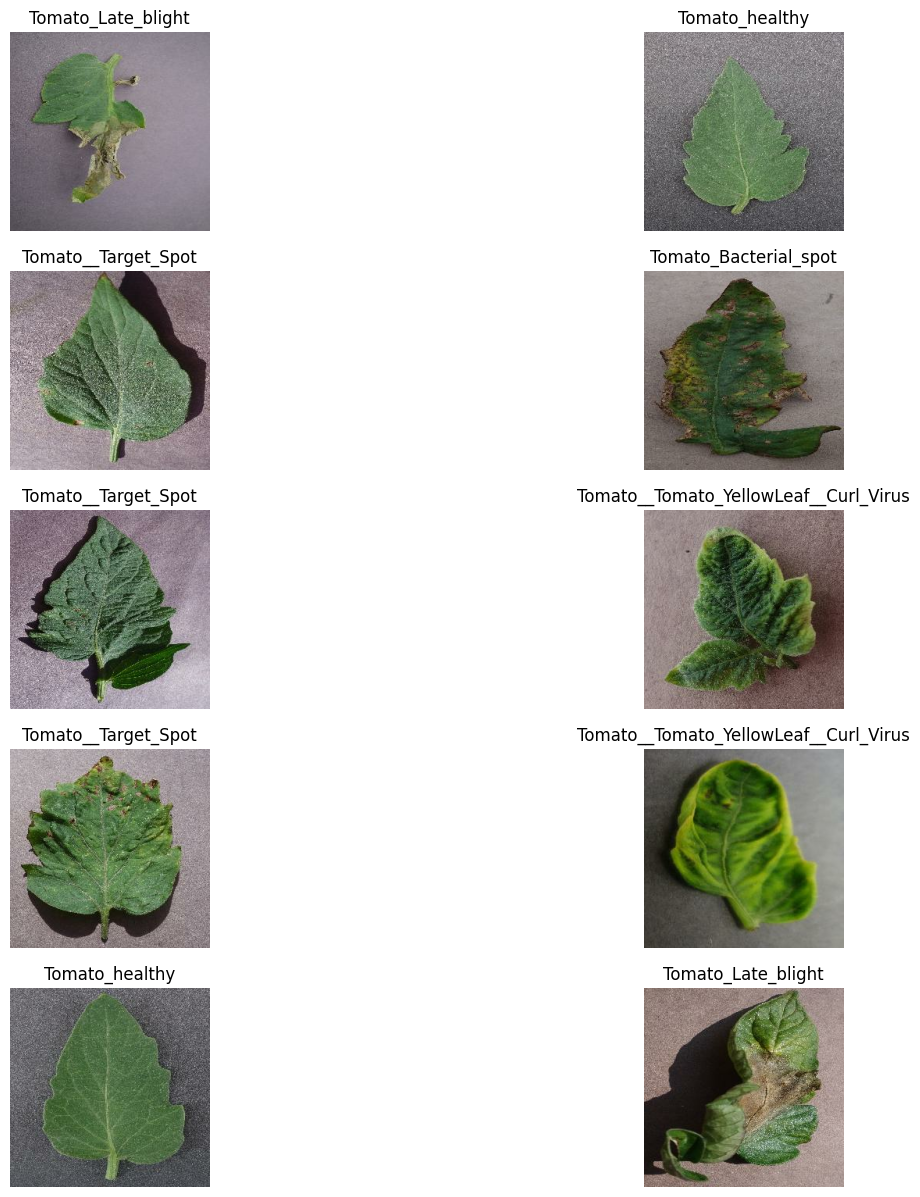

In [ ]:
plt.figure(figsize=(15, 15))
class_names = dataset.class_names # Get class names from the dataset object
for image, lable in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[lable[i].numpy()]) # Use class_names to get the title
        plt.axis('OFF')

# **Defining CNN Model Architecture**

In [ ]:
# ==========================
# MODEL: CNN with Attention (SE + Spatial + Residual + Transfer Learning)
# ==========================

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, Multiply, Input, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================
# Squeeze-and-Excitation Block
# ==========================
def se_block(input_tensor, reduction_ratio = 16):
    """ Squeeze-and-Excitation Block """
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# ==========================
# Spatial Attention Block
# ==========================
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.attention_conv = Conv2D(1, kernel_size = 7, padding='same', activation='sigmoid')

    def call(self, input_tensor):
        avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.attention_conv(concat)
        return Multiply()([input_tensor, attention])


# **Building Up CNN Model Architecture**

In [ ]:
# ==========================
# Improved CNN Model with Transfer Learning & Residual Connections
# ==========================
def build_cnn_with_attention(input_shape=(224, 224, 3), num_classes=11):
    """ CNN Model with SE Attention, Spatial Attention, Residual Connections & Transfer Learning """
    inputs = Input(shape=input_shape)

    # Transfer Learning Backbone
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputs)
    x = base_model.output

    # Residual Block - Adjusted to match the shape of 'x' after Block 1 processing
    res = Conv2D(128, (1, 1), padding='same')(x)
    res = MaxPooling2D((2, 2))(res) # Added MaxPooling2D to downsample to (3,3,128)
    res = MaxPooling2D((2, 2))(res) # Removed the second MaxPooling2D to avoid further downsampling


    # Block 1
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = se_block(x)
    x = SpatialAttention()(x)
    x = Add()([x, res])  # Residual Connection


    # Block 2 - Reduced MaxPooling2D
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # x = MaxPooling2D((2, 2))(x) # Removed MaxPooling
    x = se_block(x)
    x = SpatialAttention()(x)

    # Block 3 - Reduced MaxPooling2D
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # x = MaxPooling2D((2, 2))(x)  #Removed MaxPooling
    x = se_block(x)
    x = SpatialAttention()(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ==========================
# DATA AUGMENTATION
# ==========================
import os
import shutil

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# List of valid image extensions
VALID_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

def clean_directory(directory):
    """Removes non-image files from a directory."""
    print(f"Cleaning directory: {directory}")
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Check if the file has a valid image extension (case-insensitive)
            if not any(file_path.lower().endswith(ext) for ext in VALID_EXTENSIONS):
                print(f"Removing non-image file: {file_path}")
                try:
                    os.remove(file_path)
                except OSError as e:
                    print(f"Error removing file {file_path}: {e}")
    print(f"Finished cleaning directory: {directory}")

# Clean train and test directories before creating generators
clean_directory(train_dir)
clean_directory(test_dir)


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Cleaning directory: /content/drive/MyDrive/Tomato _ Split/train
Finished cleaning directory: /content/drive/MyDrive/Tomato _ Split/train
Cleaning directory: /content/drive/MyDrive/Tomato _ Split/test
Finished cleaning directory: /content/drive/MyDrive/Tomato _ Split/test
Found 12807 images belonging to 10 classes.
Found 3207 images belonging to 10 classes.


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

def check_images_in_directory(directory):
    """Checks all files in a directory and its subdirectories to see if they are valid images."""
    print(f"Checking images in directory: {directory}")
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                try:
                    # Open the image and try to load it to force a check
                    img = Image.open(file_path)
                    img.verify() # Verify the image integrity
                except (IOError, UnidentifiedImageError, OSError) as e:
                    print(f"Corrupted or unidentified image found: {file_path} - {e}")
                    corrupted_files.append(file_path)
    print(f"Finished checking directory: {directory}")
    return corrupted_files

# Run the check on your train and test directories
corrupted_train = check_images_in_directory(train_dir)
corrupted_test = check_images_in_directory(test_dir)

print("\nCorrupted files found in train directory:")
for f in corrupted_train:
    print(f)

print("\nCorrupted files found in test directory:")
for f in corrupted_test:
    print(f)


Checking images in directory: /content/drive/MyDrive/Tomato _ Split/train
Finished checking directory: /content/drive/MyDrive/Tomato _ Split/train
Checking images in directory: /content/drive/MyDrive/Tomato _ Split/test
Finished checking directory: /content/drive/MyDrive/Tomato _ Split/test

Corrupted files found in train directory:

Corrupted files found in test directory:


# **Training Our CNN Model Architecture**

In [ ]:
# ==========================
# TRAINING
# ==========================
NUM_CLASSES = len(train_dataset.class_indices)
cnn_with_attention = build_cnn_with_attention(num_classes=NUM_CLASSES)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1
)

print("\nTraining Improved CNN with Attention...")
history = cnn_with_attention.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# ==========================
# EVALUATION
# ==========================
test_loss, test_accuracy = cnn_with_attention.evaluate(test_dataset)
print(f"🚀 Final Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict class probabilities
y_pred_probs = cnn_with_attention.predict(test_dataset)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_dataset.classes

# Class labels
class_labels = list(test_dataset.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\n📊 Classification Report:\n")
print(report)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Improved CNN with Attention...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 477s 879ms/step - accuracy: 0.5048 - loss: 1.4290 - val_accuracy: 0.1384 - val_loss: 2.7627 - learning_rate: 1.0000e-04
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 243s 606ms/step - accuracy: 0.8774 - loss: 0.3809 - val_accuracy: 0.4163 - val_loss: 1.8900 - learning_rate: 1.0000e-04
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 244s 609ms/step - accuracy: 0.9184 - loss: 0.2526 - val_accuracy: 0.2510 - val_loss: 3.7645 - learning_rate: 1.0000e-04
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 245s 610ms/step - accuracy: 0.9362 - loss: 0.2026 - val_accuracy: 0.7877 - val_loss: 0.6577 - learning_rate: 1.0000e-04
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 247s 616ms/step - accuracy: 0.9543 - loss: 0.1444 - val_accuracy: 0.4493 - val_loss: 2.4448 - learning_rate: 1.0000e-04
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 245s 611ms/step - accuracy: 0.9595 - loss: 0.1221 - val_accuracy: 0.1949 - val_loss: 4.7223 - learning_rate: 1.0000e-04
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 

# **Evaluation of Our CNN Model Architecture**

101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step


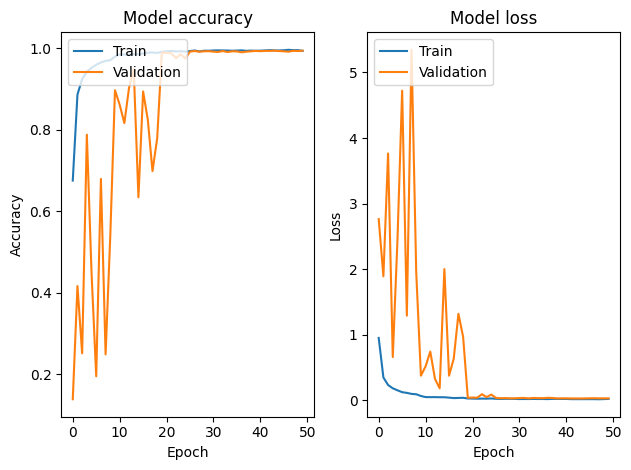

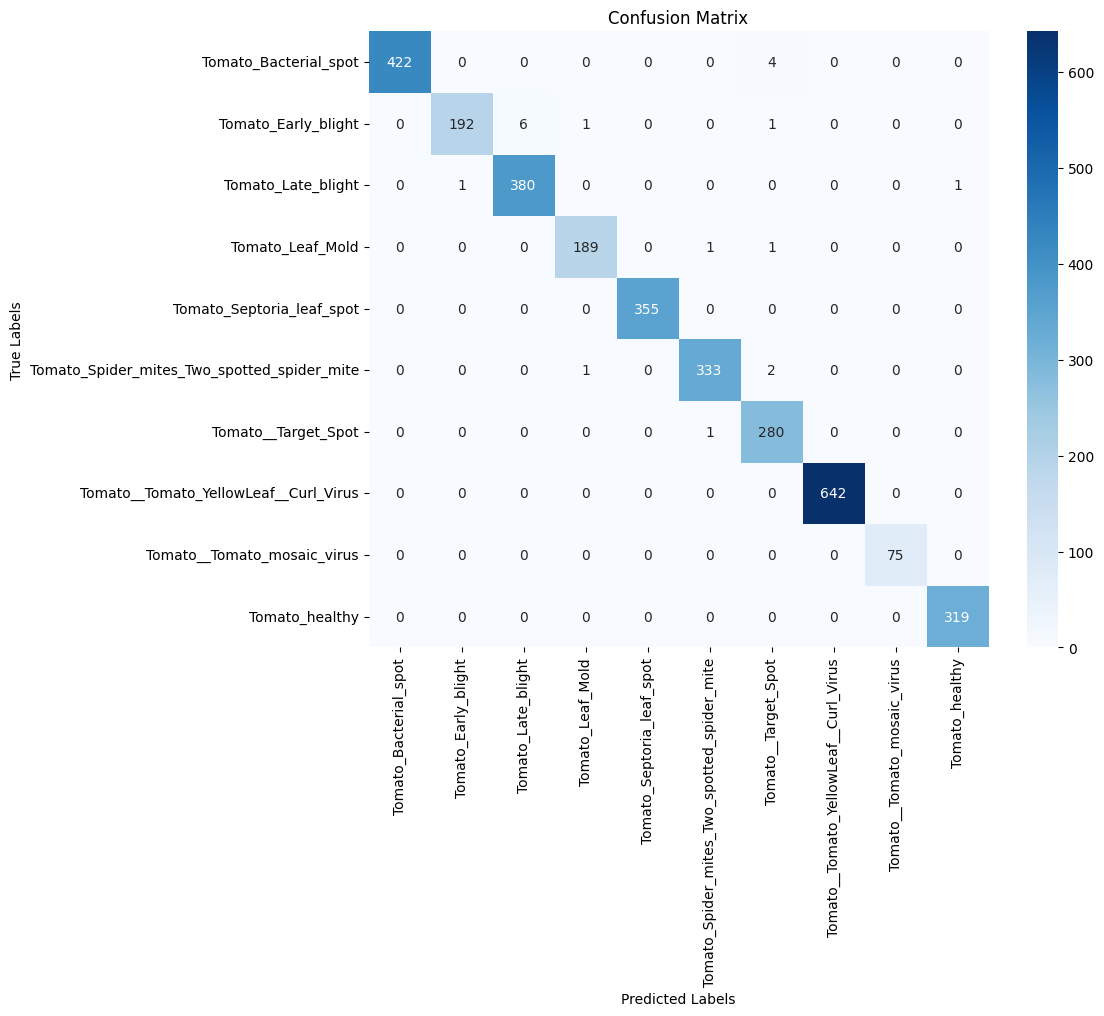

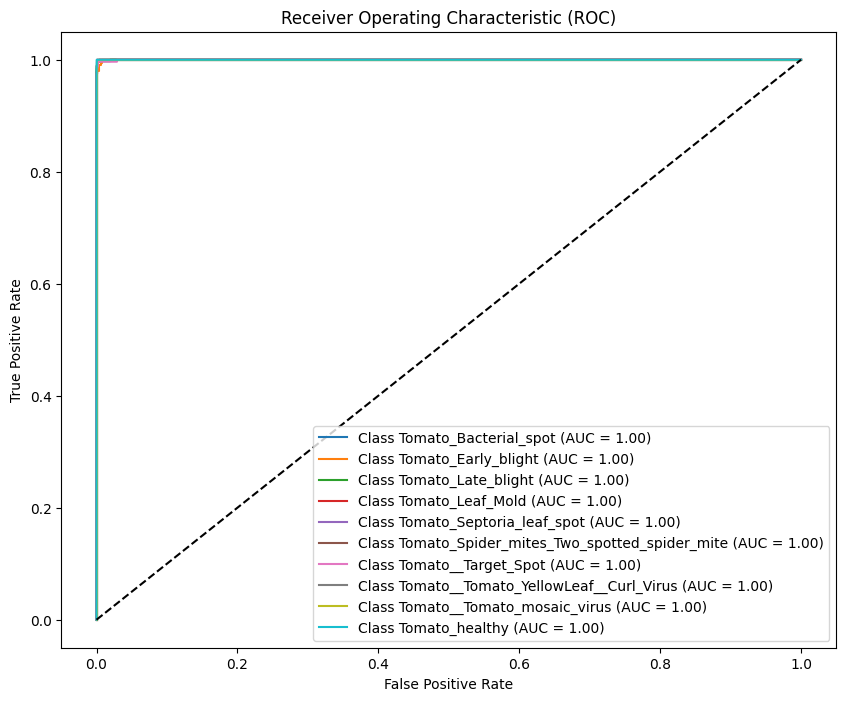

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow if not already imported

# Get true labels and predictions
y_true = test_dataset.classes
predictions = cnn_with_attention.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_dataset.class_indices.keys()), yticklabels=list(test_dataset.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true, NUM_CLASSES)[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_dataset.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# **Grad-CAM Explanability Analysis - Model Visualization**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import os # Import the os module

# ==========================
# Grad-CAM Visualization
# ==========================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last convolutional layer and the output predictions
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get the class with the highest predicted probability
        class_channel = predictions[:, pred_index]  # Get the prediction for the specific class

    # Compute gradients of the class with respect to the feature map of the last convolutional layer
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients over all feature map locations

    # Get the output feature map
    conv_outputs = conv_outputs[0]

    # Compute the weighted sum of the feature maps
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_on_image(heatmap, img_path, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to the size of the image
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255
    heatmap = np.resize(heatmap, (img.shape[0], img.shape[1]))  # Resize heatmap to match the image shape

    # Create an overlay of the heatmap on the image
    heatmap = np.expand_dims(heatmap, axis=-1)
    # Ensure img and heatmap have the same number of dimensions (add channel dimension to heatmap if needed)
    if heatmap.shape[-1] == 1 and img.shape[-1] == 3:
        heatmap = np.repeat(heatmap, 3, axis=-1)
    overlay_img = np.array(img * (1 - alpha) + heatmap * alpha, dtype=np.uint8)

    # Display the image with the heatmap overlay
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.show()


# ==========================
# Saliency Map Visualization
# ==========================
def generate_saliency_map(model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get the class with the highest predicted probability
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class with respect to the input image
    grads = tape.gradient(class_channel, img_array)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # Take the maximum of gradients across color channels
    saliency = np.uint8(255 * saliency)  # Normalize the saliency map to 0-255
    return saliency

def display_saliency_on_image(saliency, img_path):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize saliency map to the size of the image
    saliency = np.resize(saliency, (img.shape[0], img.shape[1]))  # Resize saliency map to match the image shape

    # Create an overlay of the saliency map on the image
    # Ensure img and saliency have the same number of dimensions (add channel dimension to saliency if needed)
    saliency = np.expand_dims(saliency, axis=-1)
    if saliency.shape[-1] == 1 and img.shape[-1] == 3:
         saliency = np.repeat(saliency, 3, axis=-1)
    saliency_overlay = np.array(img * 0.7 + saliency * 0.3, dtype=np.uint8)

    # Display the image with the saliency map overlay
    plt.imshow(saliency_overlay)
    plt.axis('off')
    plt.show()

# Choose an image path and prepare the image for Grad-CAM and Saliency Map
base_img_dir = '/content/drive/MyDrive/Grad_CAM_Images'
img_path = None # Initialize img_path to None

# Find the first image file in the directory
for root, _, files in os.walk(base_img_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            img_path = os.path.join(root, file)
            break # Found an image, break the loop
    if img_path:
        break # Found an image in a subdirectory, break the outer loop

if img_path:
    print(f"Processing image: {img_path}")
    # Prepare the image for the model
    img_array = image.load_img(img_path, target_size=(224, 224)) # Ensure target_size matches your model's input
    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0 # Rescale the image if your model was trained with rescaling

    # Grad-CAM: Generate heatmap and overlay on the image
    # Replace 'block5_conv3' with the name of the last convolutional layer in your actual model
    last_conv_layer_name = 'block3_conv3' # Example layer name, you need to find the correct one
    # You can inspect model.summary() to find layer names

    # Make sure the model variable is available. Assuming 'cnn_with_attention' is the model object.
    model_for_cam = cnn_with_attention # Use the trained model object

    try:
        heatmap = make_gradcam_heatmap(img_array, model_for_cam, last_conv_layer_name=last_conv_layer_name)
        display_gradcam_on_image(heatmap, img_path)

        # Saliency Map: Generate saliency map and overlay on the image
        saliency = generate_saliency_map(model_for_cam, img_array)
        display_saliency_on_image(saliency, img_path)
    except ValueError as e:
        print(f"Error during Grad-CAM or Saliency Map generation: {e}")
        print(f"Please verify the 'last_conv_layer_name' ({last_conv_layer_name}) and that the model ({model_for_cam.__class__.__name__}) is correctly defined and trained.")


else:
    print(f"No image files found in the directory: {base_img_dir}")


# The following code blocks are for evaluation and model export
# They were causing NameErrors because test_data and preds were not defined in this cell.
# Assuming y_true, y_pred, predictions, NUM_CLASSES, and test_dataset are available from previous cells.

# Ensure these variables are available. They should be if you run the notebook sequentially.
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# from tensorflow.keras.utils import to_categorical # Import to_categorical if needed
# import seaborn as sns

# # Confusion Matrix
# if 'y_true' in locals() and 'y_pred' in locals() and 'test_dataset' in locals():
#     conf_matrix = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_dataset.class_indices.keys()), yticklabels=list(test_dataset.class_indices.keys()))
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()
# else:
#     print("Skipping Confusion Matrix: Required variables (y_true, y_pred, test_dataset) not found.")

# # ROC Curve
# if 'y_true' in locals() and 'predictions' in locals() and 'NUM_CLASSES' in locals() and 'test_dataset' in locals():
#     plt.figure(figsize=(10, 8))
#     for i in range(NUM_CLASSES):
#         # Use test_dataset.class_indices.keys() for labels
#         fpr, tpr, _ = roc_curve(to_categorical(y_true, NUM_CLASSES)[:, i], predictions[:, i])
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f"Class {list(test_dataset.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.title('ROC Curve')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
#     plt.show()
# else:
#      print("Skipping ROC Curve: Required variables (y_true, predictions, NUM_CLASSES, test_dataset) not found.")


# ==========================
# Export Model to TensorFlow Lite for Edge Deployment
# ==========================
# Ensure the 'cnn_with_attention' model is available from previous cells
if 'cnn_with_attention' in locals():
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(cnn_with_attention)
        tflite_model = converter.convert()
        open('model.tflite', 'wb').write(tflite_model)
        print("✅ Model successfully exported to model.tflite")
    except Exception as e:
        print(f"Error exporting model to TFLite: {e}")
else:
    print("Skipping TFLite export: 'cnn_with_attention' model not found.")

No image files found in the directory: /content/drive/MyDrive/Grad_CAM_Images
Saved artifact at '/tmp/tmpqar31tws'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float16, name=None)
Captures:
  132476923618384: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  132476923618000: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  132477530830032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530832720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530829072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530830608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530828880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530948816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132477530950928: TensorSpec(shape=(), dtype=tf.resource, 